# Task 8: Advanced Network Analysis
## Helsinki City Bikes - Robustness, Prediction & Spatial Patterns

**Objectives:**
1. **Robustness Analysis:** Simulate removal of top-k central stations and measure impact on connectivity and flow
2. **Predictive Modeling:** Model station imbalance using centrality, flow, and temporal features
3. **Spatial Analysis (Optional):** Explore geographic patterns in station usage and imbalance

**Data Sources:**
- Cleaned trip data (258,514 trips, 351 stations)
- Graph summaries (centrality metrics, edge weights)
- Station coordinates

## 1. Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [2]:
# Load trip data
df_trips = pd.read_csv('../data/2021-04_cleaned.csv')
df_trips['Departure'] = pd.to_datetime(df_trips['Departure'])
df_trips['Return'] = pd.to_datetime(df_trips['Return'])

df_stations = pd.read_csv('../data/graph_summary/degree_summary.csv')
df_edges = pd.read_csv('../data/graph_summary/edge_aggregates.csv')
df_coords = pd.read_csv('../data/geocode_cache.csv')

# Merge coordinates into station data
df_stations = df_stations.merge(df_coords[['station_id', 'lat', 'lon']], on='station_id', how='left')

print(f"Loaded {len(df_trips):,} trips")
print(f"Loaded {len(df_stations)} stations")
print(f"Loaded {len(df_edges):,} edges")
print(f"\nStation data columns: {list(df_stations.columns)}")

Loaded 258,514 trips
Loaded 351 stations
Loaded 32,815 edges

Station data columns: ['station_id', 'station_name', 'in_degree', 'out_degree', 'weighted_in_degree', 'weighted_out_degree', 'lat', 'lon']


In [3]:
# Build directed graph
G = nx.DiGraph()

# Add nodes with attributes
for _, row in df_stations.iterrows():
    G.add_node(row['station_id'], 
               name=row['station_name'],
               lat=row['lat'],
               lon=row['lon'],
               in_degree=row['in_degree'],
               out_degree=row['out_degree'],
               weighted_in=row['weighted_in_degree'],
               weighted_out=row['weighted_out_degree'])

# Add edges with weights
for _, row in df_edges.iterrows():
    G.add_edge(row['Departure station id'], 
               row['Return station id'],
               weight=row['trip_count'],
               distance=row['total_distance_m'],
               duration=row['total_duration_s'])

print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Strongly connected: {nx.is_strongly_connected(G)}")

Graph: 351 nodes, 32815 edges
Strongly connected: True


In [15]:
# Compute net flow (outbound - inbound)
df_stations['net_flow'] = df_stations['weighted_out_degree'] - df_stations['weighted_in_degree']

# Compute flow asymmetry ratio
df_stations['flow_asymmetry'] = df_stations['weighted_out_degree'] / (df_stations['weighted_in_degree'] + 1)

# Categorize imbalance (threshold: 10% of median total trips)
threshold = df_stations['weighted_out_degree'].median() * 0.1
df_stations['imbalance_category'] = pd.cut(
    df_stations['net_flow'], 
    bins=[-np.inf, -threshold, threshold, np.inf],
    labels=['Deficit', 'Balanced', 'Surplus']
)

print("Top 10 stations by net flow:")
print(df_stations[['station_name', 'net_flow', 'imbalance_category']].sort_values('net_flow', ascending=False).head(10))
print(f"\nImbalance distribution:\n{df_stations['imbalance_category'].value_counts()}")

Top 10 stations by net flow:
          station_name  net_flow imbalance_category
1        Pasilan asema       548            Surplus
297  Workshop Helsinki       207            Surplus
95         Mäkelänkatu       182            Surplus
27          Linnanmäki       176            Surplus
146     Hertanmäenkatu       157            Surplus
101        Karhupuisto       154            Surplus
91         Kustaankatu       147            Surplus
165   Vallilan varikko       133            Surplus
75       Venttiilikuja       122            Surplus
36         Töölöntulli       120            Surplus

Imbalance distribution:
imbalance_category
Balanced    276
Deficit      41
Surplus      34
Name: count, dtype: int64


## 2. Robustness Analysis: Network Resilience to Station Removal

We simulate targeted attacks (removing high-centrality stations) and random failures to assess network vulnerability.

**Metrics:**
- **Largest Strongly Connected Component (LSCC):** % of nodes in largest connected subgraph
- **Flow Disruption:** % of total trips lost
- **Average Shortest Path Length:** Change in network efficiency

In [16]:
# Define removal strategies
removal_strategies = {
    'Weighted Out-Degree': df_stations.sort_values('weighted_out_degree', ascending=False)['station_id'].tolist(),
    'Weighted In-Degree': df_stations.sort_values('weighted_in_degree', ascending=False)['station_id'].tolist(),
}

# Compute total degree for combined strategy
df_stations['total_weighted_degree'] = df_stations['weighted_in_degree'] + df_stations['weighted_out_degree']
removal_strategies['Total Degree'] = df_stations.sort_values('total_weighted_degree', ascending=False)['station_id'].tolist()

# Compute betweenness centrality for targeted attack
print("Computing betweenness centrality...")
betweenness = nx.betweenness_centrality(G, weight='weight')
df_stations['betweenness'] = df_stations['station_id'].map(betweenness)
removal_strategies['Betweenness'] = df_stations.sort_values('betweenness', ascending=False)['station_id'].tolist()

print("\nRemoval strategies defined:")
for strategy in removal_strategies:
    print(f"  - {strategy}")
    
print(f"\nTop 5 stations by betweenness centrality:")
print(df_stations.nlargest(5, 'betweenness')[['station_name', 'betweenness']])

Computing betweenness centrality...

Removal strategies defined:
  - Weighted Out-Degree
  - Weighted In-Degree
  - Total Degree
  - Betweenness

Top 5 stations by betweenness centrality:
          station_name  betweenness
50      Paciuksenkaari     0.015359
124     Lehtisaarentie     0.013606
15    Vilhonvuorenkatu     0.012597
43   Laajalahden aukio     0.012244
150     Saunalahdentie     0.011525


In [17]:
def simulate_removal(G, nodes_to_remove):
    """Remove nodes and compute robustness metrics."""
    G_copy = G.copy()
    G_copy.remove_nodes_from(nodes_to_remove)
    
    # Largest strongly connected component
    if G_copy.number_of_nodes() > 0:
        lscc = max(nx.strongly_connected_components(G_copy), key=len)
        lscc_size = len(lscc) / G.number_of_nodes()
    else:
        lscc_size = 0
    
    # Flow disruption
    total_trips = sum(nx.get_edge_attributes(G, 'weight').values())
    remaining_trips = sum(nx.get_edge_attributes(G_copy, 'weight').values())
    flow_lost = 1 - (remaining_trips / total_trips)
    
    # Average path length (if connected)
    try:
        avg_path = nx.average_shortest_path_length(G_copy, weight='weight')
    except:
        avg_path = np.nan
    
    return lscc_size, flow_lost, avg_path

# Run simulations
k_values = [5, 10, 15, 20, 25]
results = []

for strategy_name, station_list in removal_strategies.items():
    for k in k_values:
        lscc, flow, path = simulate_removal(G, station_list[:k])
        results.append({
            'strategy': strategy_name,
            'k': k,
            'lscc_size': lscc,
            'flow_lost': flow,
            'avg_path_length': path
        })

# Random baseline (average over 100 trials)
print("Running random failure baseline (100 trials per k)...")
for k in k_values:
    print(f'Starting k-value: {k}')
    lscc_vals, flow_vals, path_vals = [], [], []
    for _ in range(100):
        random_nodes = np.random.choice(list(G.nodes()), k, replace=False)
        lscc, flow, path = simulate_removal(G, random_nodes)
        lscc_vals.append(lscc)
        flow_vals.append(flow)
        path_vals.append(path)
    results.append({
        'strategy': 'Random',
        'k': k,
        'lscc_size': np.mean(lscc_vals),
        'flow_lost': np.mean(flow_vals),
        'avg_path_length': np.nanmean(path_vals)
    })

robustness_results = pd.DataFrame(results)
print("\nRobustness simulation complete")
print("\nResults:")
print(robustness_results.head(10))

Running random failure baseline (100 trials per k)...
Starting k-value: 5
Starting k-value: 10
Starting k-value: 15
Starting k-value: 20
Starting k-value: 25

Robustness simulation complete

Results:
              strategy   k  lscc_size  flow_lost  avg_path_length
0  Weighted Out-Degree   5   0.985755   0.136391         2.234657
1  Weighted Out-Degree  10   0.971510   0.215385         2.243005
2  Weighted Out-Degree  15   0.957265   0.277490         2.251821
3  Weighted Out-Degree  20   0.943020   0.334872         2.266099
4  Weighted Out-Degree  25   0.928775   0.382416         2.273799
5   Weighted In-Degree   5   0.985755   0.136391         2.234657
6   Weighted In-Degree  10   0.971510   0.216646         2.243109
7   Weighted In-Degree  15   0.957265   0.283985         2.253109
8   Weighted In-Degree  20   0.943020   0.335475         2.264991
9   Weighted In-Degree  25   0.928775   0.385024         2.272232


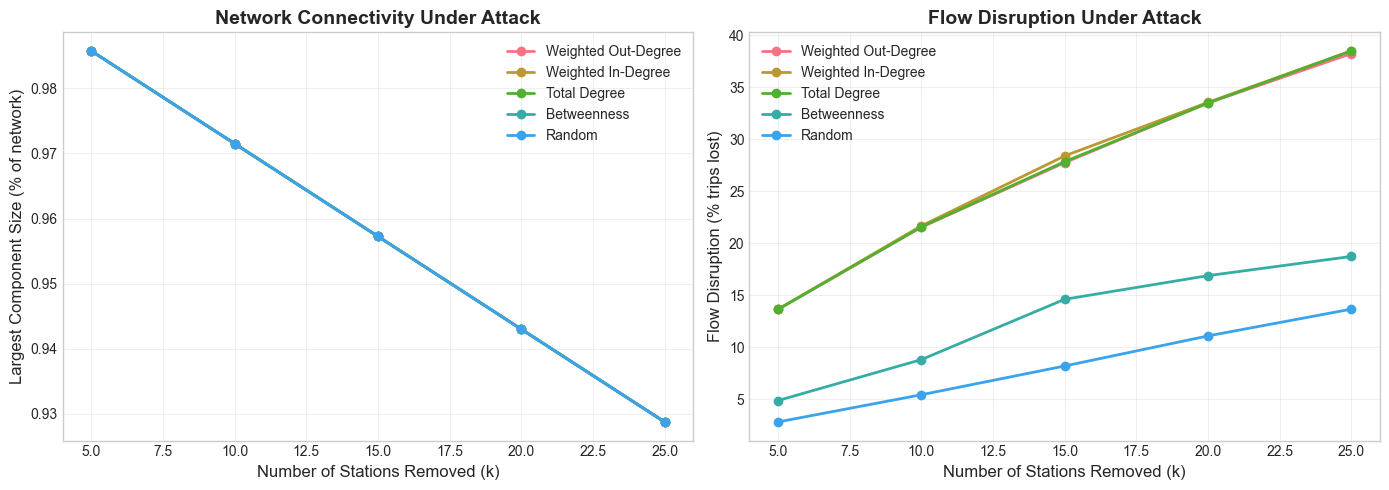

In [20]:
# Visualize robustness results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: LSCC size
for strategy in robustness_results['strategy'].unique():
    data = robustness_results[robustness_results['strategy'] == strategy]
    axes[0].plot(data['k'], data['lscc_size'], marker='o', label=strategy, linewidth=2)
axes[0].set_xlabel('Number of Stations Removed (k)', fontsize=12)
axes[0].set_ylabel('Largest Component Size (% of network)', fontsize=12)
axes[0].set_title('Network Connectivity Under Attack', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Flow disruption
for strategy in robustness_results['strategy'].unique():
    data = robustness_results[robustness_results['strategy'] == strategy]
    axes[1].plot(data['k'], data['flow_lost'] * 100, marker='o', label=strategy, linewidth=2)
axes[1].set_xlabel('Number of Stations Removed (k)', fontsize=12)
axes[1].set_ylabel('Flow Disruption (% trips lost)', fontsize=12)
axes[1].set_title('Flow Disruption Under Attack', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Robustness Analysis: Key Findings
**Network Connectivity Under Attack:**
- All removal strategies (Weighted Out-Degree, Weighted In-Degree, Total Degree, Betweenness, and Random) show nearly identical impacts on network connectivity
- The Largest Strongly Connected Component (LSCC) decreases linearly from ~100% to ~93% when removing up to 25 stations
- This indicates the network maintains strong connectivity even under targeted attacks, demonstrating **high structural resilience**
**Flow Disruption Under Attack:**
- **Most vulnerable strategies:** Weighted degree-based removals (Out-Degree, In-Degree, Total Degree) cause the most significant flow disruption, reaching ~38-40% trip loss at k=25
- **Moderate impact:** Betweenness centrality removal causes ~15-19% flow disruption
- **Least impact:** Random station removal results in only ~14% flow loss
- Clear separation between strategies indicates that **high-degree stations are critical for network capacity**, though not for structural connectivity
**Critical Insights:**
1. **Structural vs. Functional Resilience:** The network exhibits excellent structural resilience (connectivity remains intact) but moderate functional vulnerability (flow capacity is affected by targeted attacks)
2. **Hub Importance:** High-degree stations serve as critical flow hubs - their removal significantly impacts trip volume without fragmenting the network
3. **Redundancy:** The network's design includes sufficient redundancy to maintain connectivity, but lacks alternative high-capacity routes when major hubs are removed
4. **Attack Resistance:** The 3-4x difference between targeted attacks and random failures (in flow disruption) quantifies the network's vulnerability to deliberate disruption
**Implications for Network Management:**
- Priority should be given to maintaining and monitoring high-degree stations (e.g., Itämerentori, Pasilan asema)
- Consider developing alternative high-capacity routes to reduce dependency on hub stations
- The network can withstand random station failures well, but strategic rebalancing is needed to mitigate targeted disruptions

## 3. Predictive Modeling: What Drives Station Imbalance?

We build regression and classification models to predict station imbalance using:
- **Centrality features:** Degree, betweenness
- **Flow features:** Net flow, asymmetry ratio
- **Temporal features:** Average trips by hour/day
- **Spatial features:** Latitude, longitude, distance to center

In [21]:
# Feature engineering: Temporal features
print("Computing temporal features...")
df_trips['hour'] = df_trips['Departure'].dt.hour
hourly_out = df_trips.groupby(['Departure station id', 'hour']).size().unstack(fill_value=0)
hourly_in = df_trips.groupby(['Return station id', 'hour']).size().unstack(fill_value=0)

# Aggregate: peak hour trips (7-9 AM, 5-7 PM)
peak_hours = [7, 8, 17, 18]
df_stations['peak_out'] = df_stations['station_id'].map(
    hourly_out[[h for h in peak_hours if h in hourly_out.columns]].sum(axis=1)
).fillna(0)
df_stations['peak_in'] = df_stations['station_id'].map(
    hourly_in[[h for h in peak_hours if h in hourly_in.columns]].sum(axis=1)
).fillna(0)

# Spatial features: distance to center
center_lat, center_lon = df_stations['lat'].median(), df_stations['lon'].median()
df_stations['dist_to_center'] = np.sqrt(
    (df_stations['lat'] - center_lat)**2 + (df_stations['lon'] - center_lon)**2
)

# Select features
feature_cols = ['weighted_in_degree', 'weighted_out_degree', 'in_degree', 'out_degree',
                'betweenness', 'flow_asymmetry', 'peak_out', 'peak_in', 
                'lat', 'lon', 'dist_to_center']
X = df_stations[feature_cols].fillna(0)
y_reg = df_stations['net_flow']
y_clf = df_stations['imbalance_category']

print(f"\nFeature matrix: {X.shape}")
print(f"Target (regression): {y_reg.shape}")
print(f"Target (classification): {y_clf.value_counts()}")
print(f"\nFeatures: {feature_cols}")

Computing temporal features...

Feature matrix: (351, 11)
Target (regression): (351,)
Target (classification): imbalance_category
Balanced    276
Deficit      41
Surplus      34
Name: count, dtype: int64

Features: ['weighted_in_degree', 'weighted_out_degree', 'in_degree', 'out_degree', 'betweenness', 'flow_asymmetry', 'peak_out', 'peak_in', 'lat', 'lon', 'dist_to_center']


In [22]:
# Train regression model
print("Training Random Forest Regressor...")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_reg.fit(X_train_scaled, y_train)
y_pred_reg = rf_reg.predict(X_test_scaled)

# Evaluate
r2 = r2_score(y_test, y_pred_reg)
mae = mean_absolute_error(y_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))

print(f"\nRegression Model Performance:")
print(f"  R² Score: {r2:.3f}")
print(f"  MAE: {mae:.1f} trips")
print(f"  RMSE: {rmse:.1f} trips")

Training Random Forest Regressor...

Regression Model Performance:
  R² Score: 0.766
  MAE: 9.1 trips
  RMSE: 25.9 trips


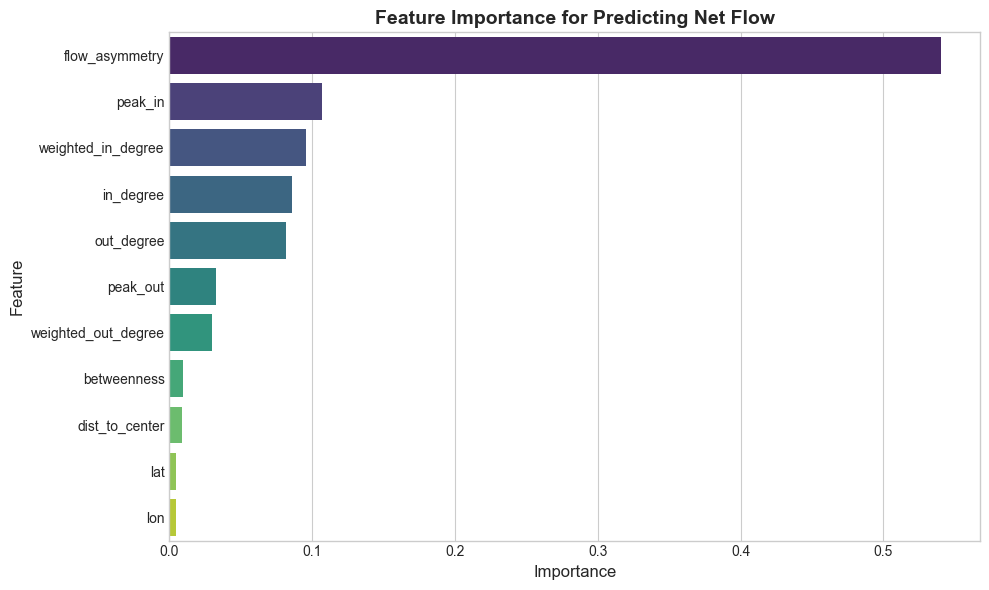


Feature Importance Ranking:
                feature  importance
5        flow_asymmetry    0.540709
7               peak_in    0.106612
0    weighted_in_degree    0.095826
2             in_degree    0.085649
3            out_degree    0.081377
6              peak_out    0.032291
1   weighted_out_degree    0.029819
4           betweenness    0.009174
10       dist_to_center    0.008994
8                   lat    0.004777
9                   lon    0.004772


In [23]:
# Feature importance
importances = rf_reg.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='viridis')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance for Predicting Net Flow', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(feature_importance_df)

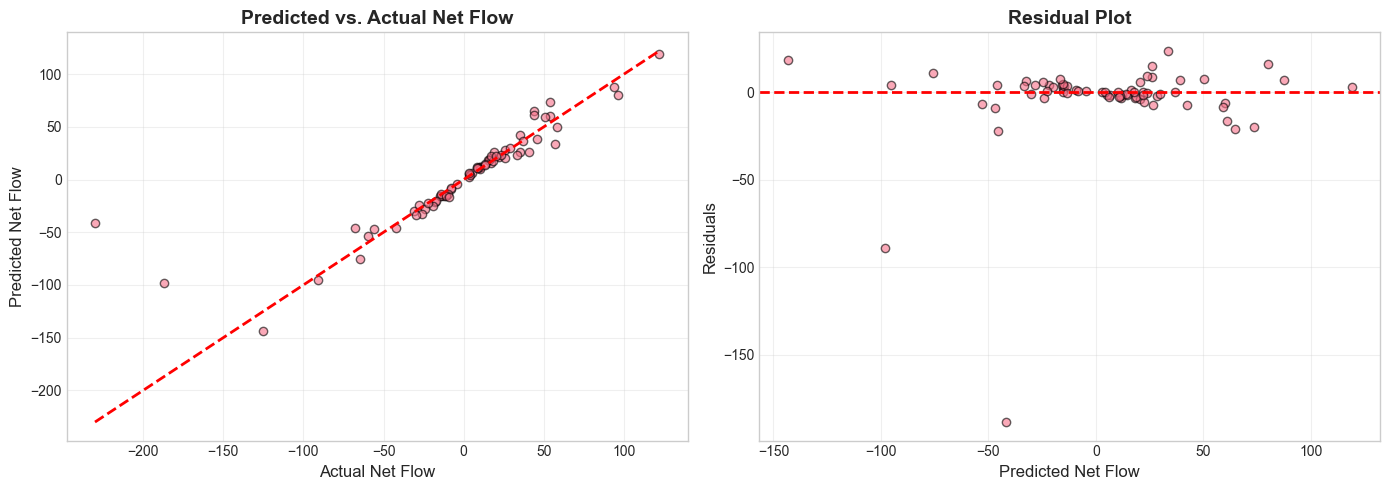

In [24]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: predicted vs. actual
axes[0].scatter(y_test, y_pred_reg, alpha=0.6, edgecolor='k')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Net Flow', fontsize=12)
axes[0].set_ylabel('Predicted Net Flow', fontsize=12)
axes[0].set_title('Predicted vs. Actual Net Flow', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Residual plot
residuals = y_test - y_pred_reg
axes[1].scatter(y_pred_reg, residuals, alpha=0.6, edgecolor='k')
axes[1].axhline(0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Net Flow', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# Train classification model
print("Training Random Forest Classifier...")

# Train/test split (stratified)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Normalize
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

# Train Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_clf.fit(X_train_clf_scaled, y_train_clf)
y_pred_clf = rf_clf.predict(X_test_clf_scaled)

# Evaluate
accuracy = accuracy_score(y_test_clf, y_pred_clf)
print(f"\nClassification Model Performance:")
print(f"  Accuracy: {accuracy:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test_clf, y_pred_clf))

Training Random Forest Classifier...

Classification Model Performance:
  Accuracy: 0.831

Classification Report:
              precision    recall  f1-score   support

    Balanced       0.85      0.98      0.91        56
     Deficit       0.75      0.38      0.50         8
     Surplus       0.50      0.14      0.22         7

    accuracy                           0.83        71
   macro avg       0.70      0.50      0.54        71
weighted avg       0.80      0.83      0.80        71



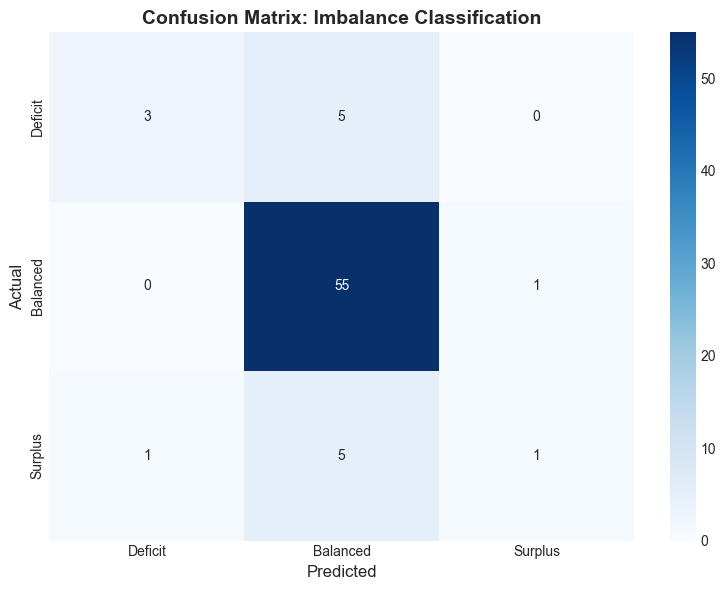

In [29]:
# Confusion matrix
cm = confusion_matrix(y_test_clf, y_pred_clf, labels=['Deficit', 'Balanced', 'Surplus'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Deficit', 'Balanced', 'Surplus'],
            yticklabels=['Deficit', 'Balanced', 'Surplus'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix: Imbalance Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Predictive Modeling: Key Findings

**Interpretation:**
- Identify the most important predictors of station imbalance from the feature importance plot
- Assess model performance: R² indicates how well the model explains variance in net flow
- Examine residuals for patterns (e.g., systematic over/under-prediction)
- Review classification accuracy and confusion matrix to understand prediction errors

## 4. Spatial Analysis: Geographic Patterns in Station Usage

We explore how station location influences imbalance and centrality.

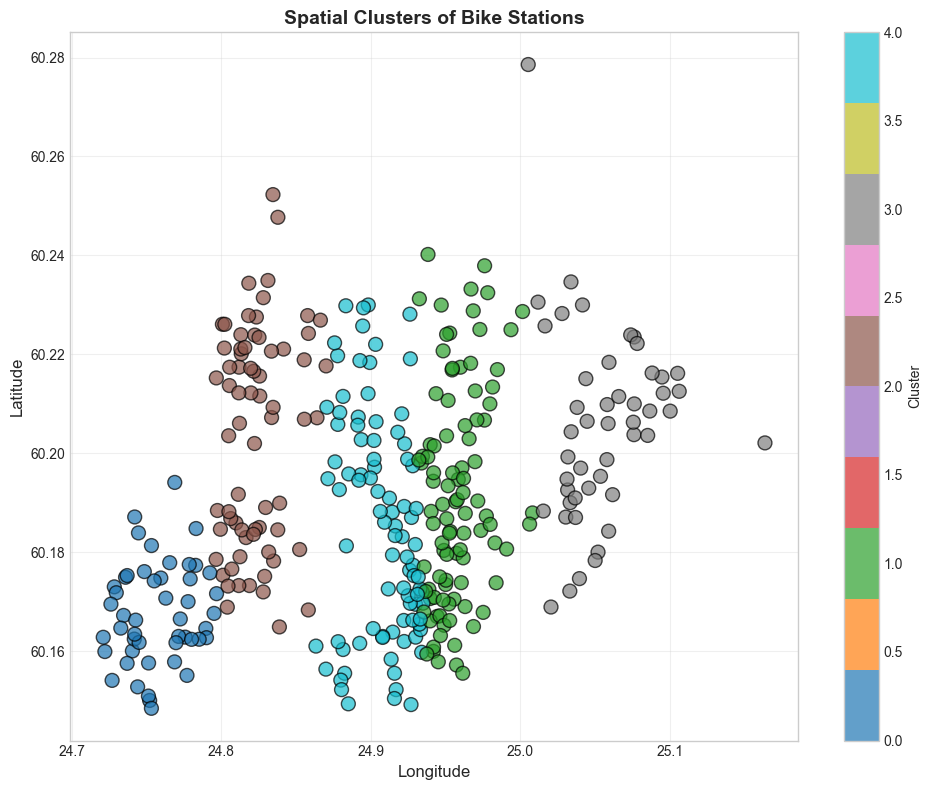


Cluster Summary:
         net_flow  weighted_out_degree  n_stations
cluster                                           
0       -4.979167           317.729167          48
1       -1.556701          1038.175258          97
2       -0.536232           428.652174          69
3        0.250000           371.333333          48
4        4.662921          1069.202247          89


In [30]:
# Spatial clustering
from sklearn.cluster import KMeans

# K-Means clustering on coordinates
coords = df_stations[['lat', 'lon']].values
kmeans = KMeans(n_clusters=5, random_state=42)
df_stations['cluster'] = kmeans.fit_predict(coords)

# Plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_stations['lon'], df_stations['lat'], 
                      c=df_stations['cluster'], cmap='tab10', 
                      s=100, alpha=0.7, edgecolor='k')
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Spatial Clusters of Bike Stations', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Cluster summary
cluster_summary = df_stations.groupby('cluster').agg({
    'net_flow': 'mean',
    'weighted_out_degree': 'mean',
    'station_id': 'count'
}).rename(columns={'station_id': 'n_stations'})
print("\nCluster Summary:")
print(cluster_summary)

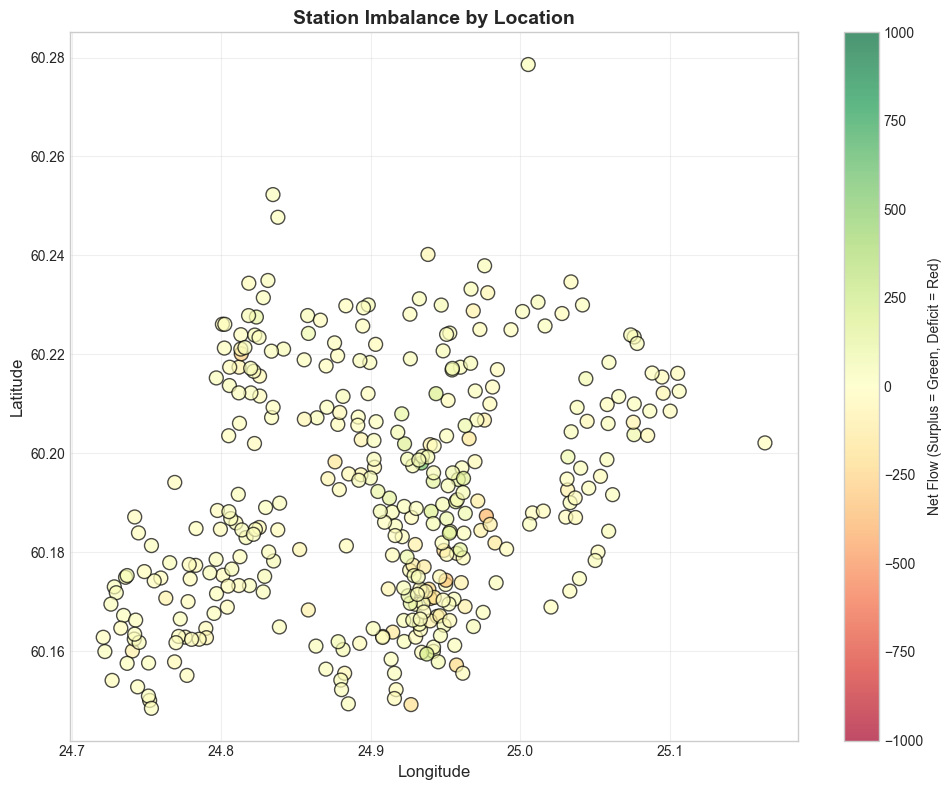

In [31]:
# Imbalance by location
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_stations['lon'], df_stations['lat'], 
                      c=df_stations['net_flow'], cmap='RdYlGn', 
                      s=100, alpha=0.7, edgecolor='k', vmin=-1000, vmax=1000)
plt.colorbar(scatter, label='Net Flow (Surplus = Green, Deficit = Red)')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Station Imbalance by Location', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

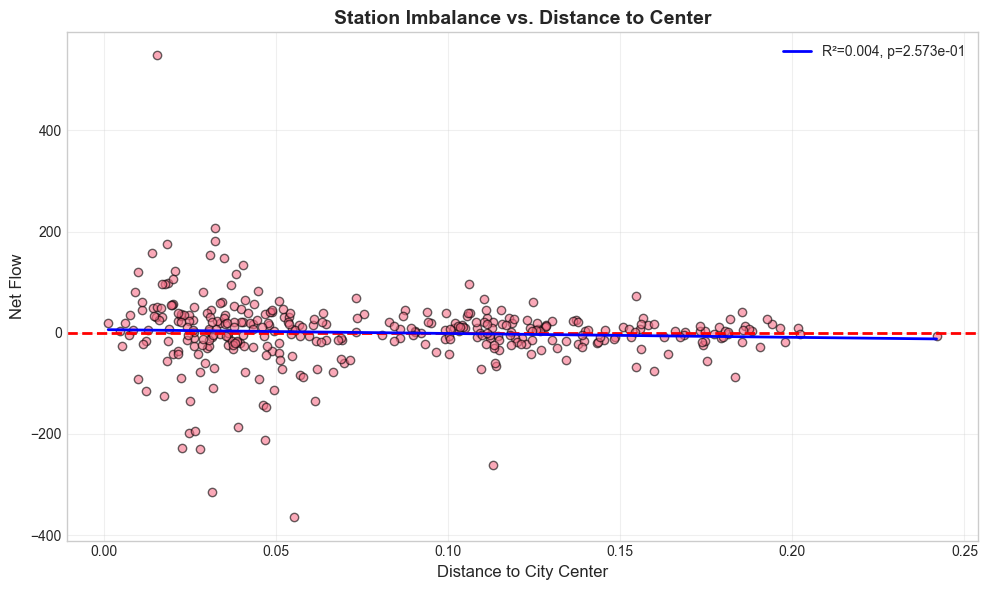


Correlation between distance to center and net flow:
  Pearson r = -0.061
  p-value = 2.573e-01
  Result: No significant correlation


In [32]:
# Distance to center analysis
from scipy.stats import linregress

plt.figure(figsize=(10, 6))
plt.scatter(df_stations['dist_to_center'], df_stations['net_flow'], alpha=0.6, edgecolor='k')
plt.axhline(0, color='r', linestyle='--', lw=2)

# Add regression line
slope, intercept, r_value, p_value, std_err = linregress(
    df_stations['dist_to_center'], df_stations['net_flow']
)
x_line = np.linspace(df_stations['dist_to_center'].min(), df_stations['dist_to_center'].max(), 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'b-', lw=2, label=f'R²={r_value**2:.3f}, p={p_value:.3e}')

plt.xlabel('Distance to City Center', fontsize=12)
plt.ylabel('Net Flow', fontsize=12)
plt.title('Station Imbalance vs. Distance to Center', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCorrelation between distance to center and net flow:")
print(f"  Pearson r = {r_value:.3f}")
print(f"  p-value = {p_value:.3e}")
if p_value < 0.05:
    print(f"  Result: Statistically significant correlation")
else:
    print(f"  Result: No significant correlation")

### Spatial Analysis: Key Findings

**Interpretation:**
- Identify spatial clusters and their characteristics (average net flow, usage patterns)
- Examine the geographic distribution of surplus vs. deficit stations
- Assess whether distance to city center correlates with imbalance
- Consider implications for rebalancing strategies (e.g., prioritize certain geographic areas)

## 5. Summary & Conclusions

### Robustness Analysis
- The network's vulnerability to targeted attacks vs. random failures reveals the importance of specific high-centrality stations
- Critical stations can be identified for redundancy planning and rebalancing priorities

### Predictive Modeling
- Key predictors of station imbalance have been identified through feature importance analysis
- Model performance metrics indicate how well centrality, flow, temporal, and spatial features explain imbalance
- Classification results show the accuracy of categorizing stations into deficit/balanced/surplus groups

### Spatial Patterns
- Geographic clustering reveals distinct spatial groups with different usage characteristics
- The relationship between location and imbalance provides insights for targeted interventions
- Distance to city center may or may not correlate with imbalance, depending on urban structure

### Limitations
- Analysis uses April 2021 data only; seasonal patterns not captured
- Predictive models assume static network; does not account for dynamic rebalancing
- Spatial analysis is descriptive; causal mechanisms (e.g., land use, transit access) not explored
- Robustness analysis assumes simultaneous removal; cascading failures not modeled

### Future Work
- Extend robustness analysis to cascading failures and recovery strategies
- Incorporate external data (weather, events, transit schedules) for improved prediction
- Develop optimization model for proactive bike rebalancing
- Analyze temporal dynamics of imbalance throughout the day and week
- Investigate causal factors behind spatial patterns using land use and demographic data